### Import

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

### 1-1) 1. (적당히) 높은 해상도를 가진 이미지 선택

In [40]:
path = os.path.join(os.getenv("HOME"), 'Downloads', 'anger1.jpg')
path

'/home/aiffel-dj51/Downloads/anger1.jpg'

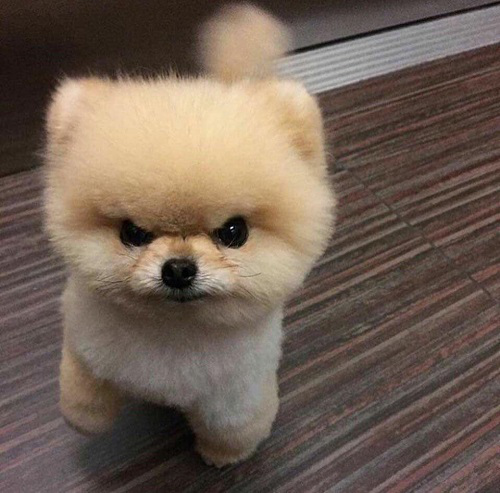

In [41]:
img = Image.open(path)
img

In [42]:
hr = np.array(img)
h, w, c = hr.shape
hr.shape

(493, 500, 3)

### 1-1) 2.해상도 줄이기

In [43]:
lr = cv2.resize(hr, dsize=(w//4, h//4), interpolation=cv2.INTER_CUBIC)

In [44]:
bicubic_hr = cv2.resize(
    lr,
    dsize = (w, h),
    interpolation = cv2.INTER_CUBIC
)

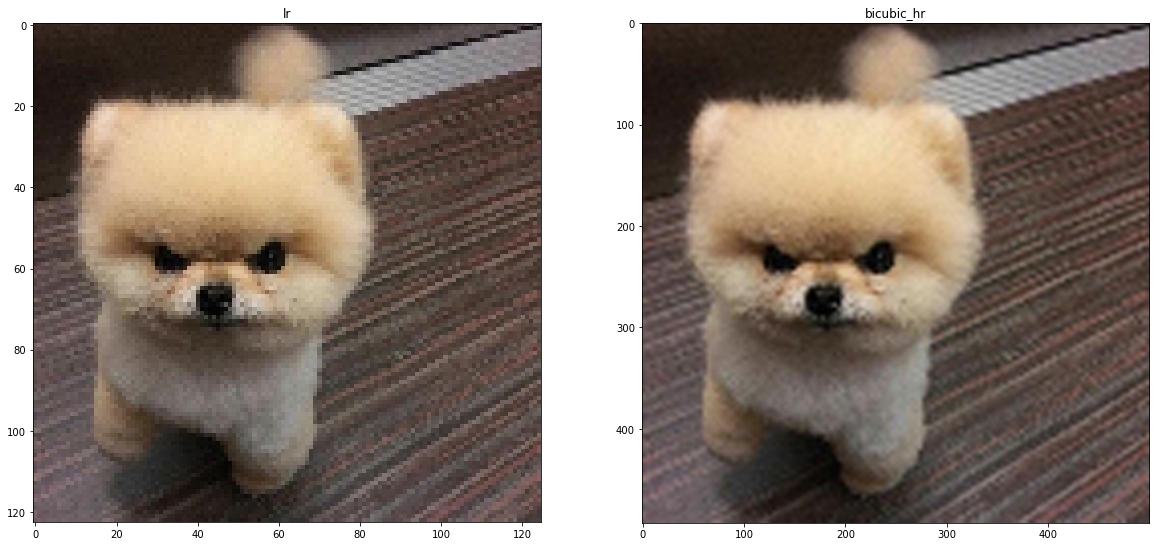

In [45]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.title('lr')
plt.imshow(lr)
plt.subplot(1,2,2)
plt.title('bicubic_hr')
plt.imshow(bicubic_hr)
plt.show()

### 1-1) 3. SRGAN

In [46]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [47]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

In [48]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [49]:
srgan_hr = apply_srgan(lr)

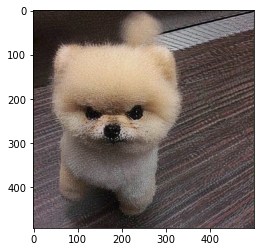

In [50]:
plt.imshow(srgan_hr)
plt.show()

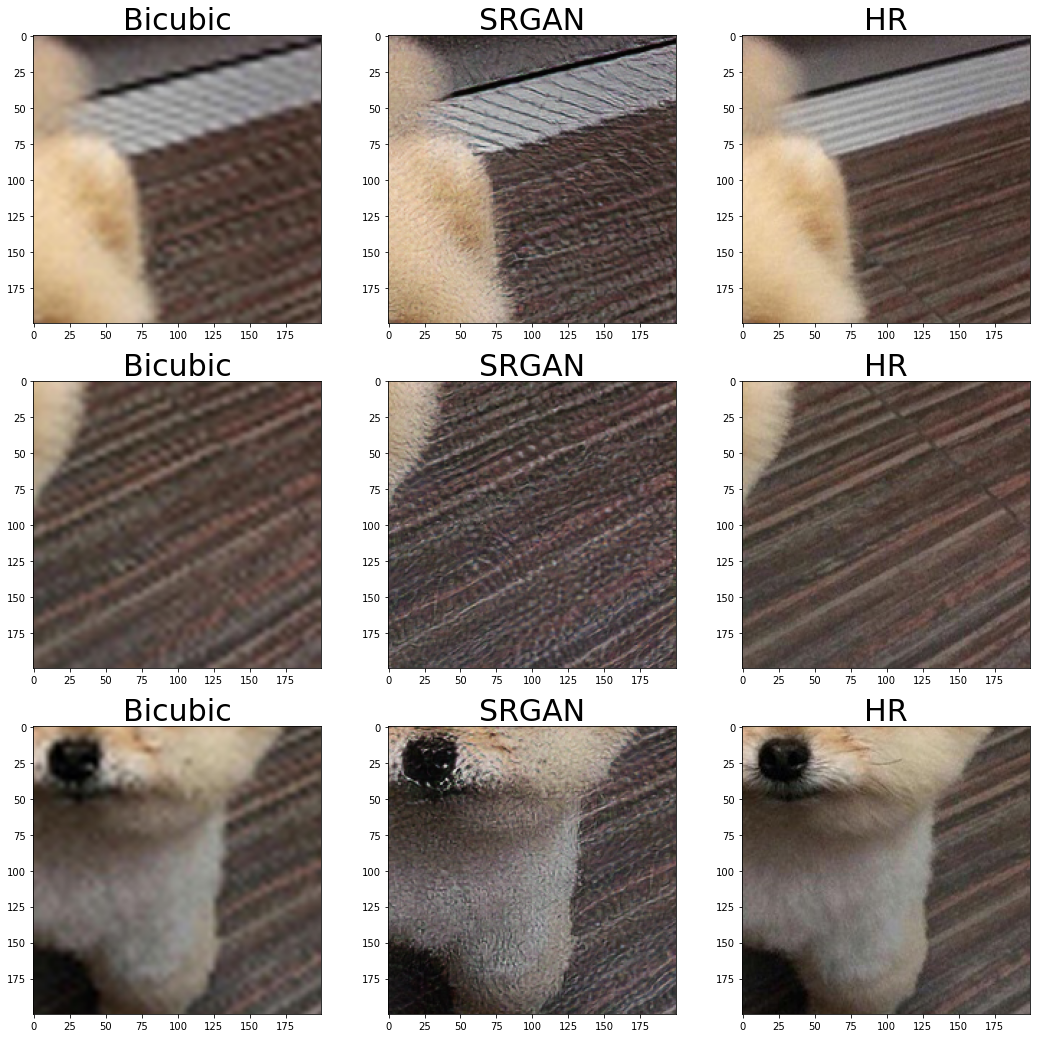

In [51]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(10,250), (200,300), (250,150)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 1-2) 1. 해상도가 낮은 이미지 찾아오기

In [37]:
lr_path = os.path.join(os.getenv('HOME'), 'Downloads', 'lr_dog3.jpg')
lr_path

'/home/aiffel-dj51/Downloads/lr_dog3.jpg'

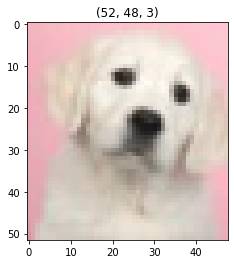

In [38]:
img = Image.open(lr_path)
lr = np.array(img)
plt.title(lr.shape)
plt.imshow(lr)
plt.show()

### 1-2) 2. Bicubic, SRGAN 적용

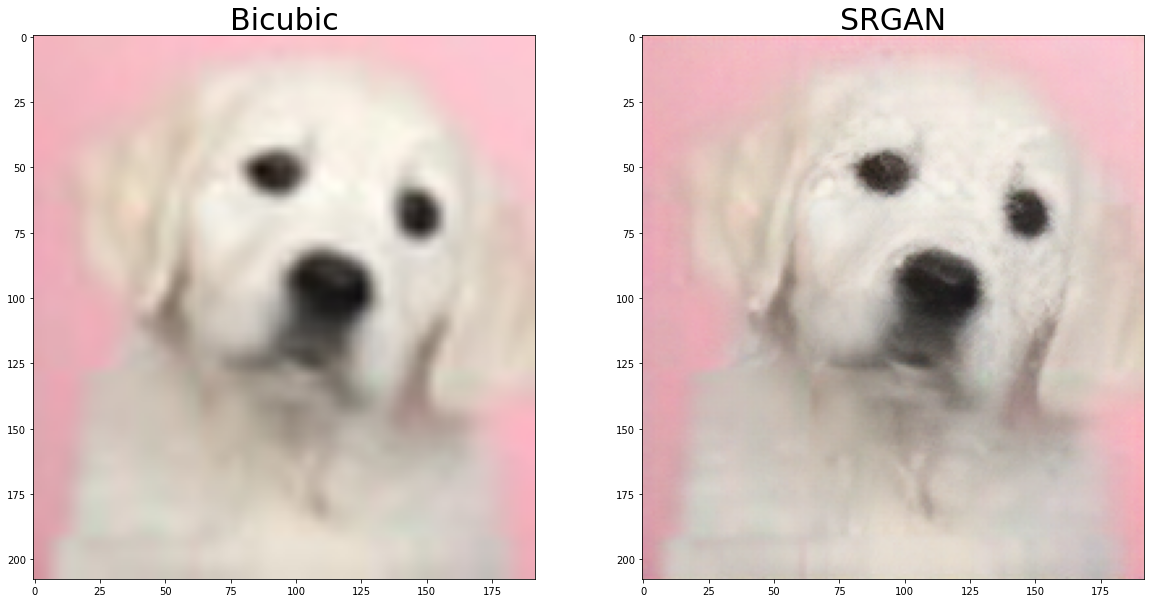

In [39]:
plt.figure(figsize=(20,10))

# SRGAN을 이용해 고해상도로 변환합니다.
srgan_img = apply_srgan(lr)

# bicubic interpolation
bicubic_img = cv2.resize(
    lr, 
    (lr.shape[1]*4, lr.shape[0]*4), 
    interpolation=cv2.INTER_CUBIC
)

# 전체 이미지를 시각화합니다.

plt.subplot(121)
plt.title('Bicubic', fontsize=30)
plt.imshow(bicubic_img)

plt.subplot(122)
plt.title('SRGAN', fontsize=30)
plt.imshow(srgan_img)

plt.show()

### 프로젝트 2 : gif에 SRGAN 적용시키기

### 2) 1. 라이브러리 import

In [25]:
from glob import glob
import cv2
import imageio
from IPython.display import Image as show_gif

### 2) 2. 경로 불러오기

In [26]:
gif_paths = glob(os.path.join(os.getenv("HOME"), 'Downloads/Super_Resolution_project', '*lr.gif'))

In [27]:
gif_paths

['/home/aiffel-dj51/Downloads/Super_Resolution_project/city_night_lr.gif',
 '/home/aiffel-dj51/Downloads/Super_Resolution_project/fire_lr.gif',
 '/home/aiffel-dj51/Downloads/Super_Resolution_project/book_lr.gif',
 '/home/aiffel-dj51/Downloads/Super_Resolution_project/metro_lr.gif',
 '/home/aiffel-dj51/Downloads/Super_Resolution_project/wine_lr.gif']

In [28]:
def load_gif(gif_paths) :
    gif_path = gif_paths[np.random.randint(len(gif_paths))]
    gif = cv2.VideoCapture(gif_path)

    isTrue = True
    frames = []
    while isTrue:
        isTrue, frame = gif.read()
        if isTrue:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            
    return frames

### 2) 3. SRGAN 적용하기¶

In [29]:
def apply_srgan_gif(frames, ratio=1, isTrue=True):
    ret_frames = []
    if isTrue:
        for i in range(len(frames)):
            if i <= int(len(frames)*ratio):  
                ret_frames.append(apply_srgan(frames[i]))
            else :
                ret_frames.append(cv2.resize(
                    frames[i],
                    (frames[i].shape[1]*4, frames[i].shape[0]*4),
                    interpolation = cv2.INTER_CUBIC
                ))
        print(f'전체 {len(frames)} 프레임 중에서 {int(len(frames)*0.8)} 프레임만 SRGAN적용')

    else :
        for i in range(len(frames)):
            ret_frames.append(cv2.resize(
                frames[i],
                (frames[i].shape[1]*4, frames[i].shape[0]*4),
                interpolation = cv2.INTER_CUBIC
            ))
#         frames = list(map(lambda x : cv2.resize(x, (x.shape[1]*4, x.shape[0]*4), interpolation=cv2.INTER_CUBIC), frames))
        print("SRGAN 미적용")

    return ret_frames

In [30]:
origin_frames = load_gif(gif_paths)
        
print(f'frame수: {len(origin_frames)}')
print(f'frame 크기: {origin_frames[0].shape}')

frame수: 35
frame 크기: (252, 282, 3)


In [31]:
hr_gif = apply_srgan_gif(origin_frames, 0.8)

전체 35 프레임 중에서 28 프레임만 SRGAN적용


In [32]:
lr_gif = apply_srgan_gif(origin_frames, isTrue=False)

SRGAN 미적용


### 결과물 저장 및 시각화

In [33]:
imageio.mimsave("고해상도.gif", hr_gif)

In [34]:
imageio.mimsave("저해상도.gif", lr_gif)

In [52]:
#show_gif("고해상도.gif", width=800)

In [53]:
#show_gif("저해상도.gif", width=800)

### 느낀점(회고)

#### 프로젝트 1-1 정리

    - 단순히 해상도를 높이는 resize함수와 Bicubic 보간법을 사용하는 것 보다는 DIV2K 데이터셋으로 학습시킨 SRGAN모델의 결과물이 더 경계선의 구분이 명확해졌다.
    - 하지만 실제 데이터만큼의 강아지 털의 부드러운 질감의 느낌까지는 표현하지 못했다.
    - 다시 정리해보면
        1.단순히 Bicubic 보간법으로 resize를 사용한 것 보다는 SRGAN이 좀 더 경계선도 명확해지고 전반적으로 더 알아보기 쉽게 성공적으로 해상도가 올라갔다.
        2.하지만 기존이 DIV2K 데이터셋으로 SRGAN을 적용시키는 것과는 다르게 경계부분이 너무 과도하게 명확해지는 결과가 나왔다.

#### 프로젝트 1-2 정리

    - 기존에 48X48사이즈의 저해상도 이미지를 가져왔다.
    - 이렇게 비교를 해보면 원본의 사이즈가 원래부터 작아서 비교할 순 없지만 bicubic 방식으로 보간한 방법보다는 확실히 SRGAN을 통해서 해상도를 높이는 것이 훨신 성능이 좋은걸 확인할 수 있었다.

#### 프로젝트 2 정리

    - 결과물 링크
        - '고해상도.gif': https://github.com/carrot2orange/aiffel/blob/master/%EA%B3%A0%ED%95%B4%EC%83%81%EB%8F%84.gif
        - '저해상도.gif': https://github.com/carrot2orange/aiffel/blob/master/%EC%A0%80%ED%95%B4%EC%83%81%EB%8F%84.gif
    - '고해상도.gif'의 경우 ratio값을 0.8로 주어서 전체 길이의 80퍼센트는 SRGAN을 적용, 나머지 뒷부분은 bicubic방법으로 보간하여서 resize만 수행했다.
    - '저해상도.gif'의 경우 처음부터 끝까지 SRGAN을 사용하지 않고 resize만 적용하였다.
